# Summary

In [1]:
from abstractor.train import get_training_batch as get_abstractor_training_batch
from abstractor.utils import AbstractorModel, AbstractorModelRNN
from abstractor.utils import obtain_initial_hidden_states
from bert.utils import obtain_sentence_embeddings
from bert.utils import obtain_word_embeddings
from data.utils import load_training_dictionaries
from extractor.train import get_training_batch as get_extractor_training_batch
from extractor.utils import ExtractorModel
from extractor.train import convert_training_dict
from pytorch_transformers import BertModel
from pytorch_transformers import BertTokenizer
from matplotlib import pyplot as plt
from rl_connection.utils import RLModel
from rl_connection.train import get_training_batch as get_rl_training_batch
from rouge import Rouge

import numpy as np
import pickle
import torch

In [2]:
def print_results(results):
    for x in results:
        print(f'{x}\n')

## Load data

In [3]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [26]:
data = load_training_dictionaries()
documents, extraction_labels = convert_training_dict(data)

## Extractor

In [5]:
# Load extractor model:
extractor_model = ExtractorModel(bert_tokenizer, bert_model)
extractor_model_path = "results/models/extractor.pt"
extractor_model.load_state_dict(torch.load(extractor_model_path))

<All keys matched successfully>

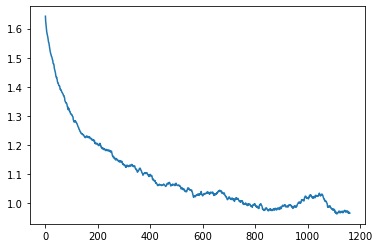

In [8]:
ext_training_loss = pickle.load(open('results/losses/extractor_training_losses.pkl', 'rb'))

def get_moving_average(a, n=3) :
    moving_average = np.cumsum(a, dtype=float)
    moving_average[n:] = moving_average[n:] - moving_average[:-n] # Shift and subtract
    moving_average = moving_average[n - 1:] / n
    return moving_average


moving_average = get_moving_average(ext_training_loss, n=100)
plt.plot(moving_average)
plt.show()

In [9]:
sentence_embeddings, sentence_mask = obtain_sentence_embeddings(
    extractor_model.bert_model, 
    extractor_model.bert_tokenizer, 
    documents
)

In [10]:
samp_embeddings, samp_masks, samp_labels, samp_indicies = get_extractor_training_batch(
    sentence_embeddings,
    sentence_mask,
    extraction_labels,
    batch_size=4
)


doc_lengths = torch.sum(samp_masks, dim=1)
samp_embeddings = torch.nn.utils.rnn.pack_padded_sequence(
    samp_embeddings,
    lengths=doc_lengths,
    batch_first=True,
    enforce_sorted=False
)


# Predict probability of extraction per sentence
extraction_probabilities, extraction_mask = extractor_model(samp_embeddings, samp_masks, samp_labels)

for batch_idx, ext_probs in enumerate(extraction_probabilities):
    doc = documents[samp_indicies[batch_idx]]
    
#     ext_sent_indicies = torch.tensor(range(extraction_mask[batch_idx].sum()))
    ext_sent_indicies = torch.argmax(ext_probs, dim=-1)[:extraction_mask[batch_idx].sum()]

    predicted_ext_sents = np.array(doc)[ext_sent_indicies]
    target_ext_sents = np.array(doc)[torch.where(samp_labels[batch_idx])]
    
    
    print("############### PREDICTIONS: ###############")
    print_results(predicted_ext_sents)
    print("############### TARGETS: ###############")
    print_results(target_ext_sents)
    print('--------------------------------------------------------')
    print('--------------------------------------------------------')
    print('--------------------------------------------------------\n')
    

############### PREDICTIONS: ###############
alison wilson , 36 , ( pictured ) died after stopping to help break up a late - night street row between a man and a woman with a baby in widnes , cheshire .

alison wilson , 36 , is believed to have been returning to her home in widnes , cheshire , when she spotted a disturbance between the man and the mother and baby .

she was taken to whiston hospital following the incident at about 11.20 pm on saturday , march 7 , but died from her injuries six days later on march 13 .

she was taken to whiston hospital following the incident at about 11.20 pm on saturday , march 7 , but died from her injuries six days later on march 13 .

mrs wilson joined another passer - by in trying to break up the row in a residential street in widnes , cheshire , ( pictured ) at 11.20 pm on march 7 but suffered serious injuries after being attacked while trying to intervene .

stephen duggan , 27 , of no fixed abode , was arrested in connection with the incident a

## Tinkering

In [28]:
data = load_training_dictionaries()
documents, ext_labs = convert_training_dict(data)

In [32]:
batch_size = 4 

batch_state, mask, samp_labels, samp_indicies = get_extractor_training_batch(
    sentence_embeddings,
    sentence_mask,
    ext_labs,
    batch_size=batch_size
)

n_label_sents = samp_labels.sum(-1)
# Obtain maximum number of sentences to extract
if n_label_sents is None:
    n_doc_sents = mask.sum(dim=1)
    batch_max_n_ext_sents = torch.tensor([self.max_n_ext_sents] * batch_size)
    batch_max_n_ext_sents = torch.min(batch_max_n_ext_sents.float(), n_doc_sents)
else:
    batch_max_n_ext_sents = n_label_sents

# Create variables to stop extraction loop
max_n_ext_sents = batch_max_n_ext_sents.max()  # Maximum number of sentences to extract
n_actions = batch_state.shape[1]
stop_action_idx = n_actions - 1  # Previously appended stop_action embedding
is_stop_action = torch.zeros(batch_size).bool()

doc_lengths = torch.sum(samp_masks, dim=1)
batch_state = torch.nn.utils.rnn.pack_padded_sequence(
    batch_state,
    lengths=doc_lengths,
    batch_first=True,
    enforce_sorted=False
)

# Extraction loop
action_indicies, ext_sents, action_dists, stop_action_list = list(), list(), list(), list()
n_ext_sents = 0
is_first_sent = True
extraction_labels = None
while True:
    # Obtain distribution amongst sentences to extract
    if is_first_sent:
        action_probs, __ = extractor_model.forward(batch_state, mask)
        is_first_sent = False
    else:
        action_probs, action_mask = extractor_model.forward(
            sent_embeddings=batch_state,
            sent_mask=mask,
            extraction_indicator=extraction_labels,
            use_init_embedding=False
        )

#     # Don't select already extracted sentences
#     # Todo: Fix this, something is wrong with the shapes.
#     if action_indicies:
#         indicies_to_ignore = torch.cat(action_indicies).T
#         extraction_mask = torch.ones(action_probs.shape)
#         batch_idx = [[x] for x in range(batch_size)]
#         extraction_mask[batch_idx, 0, indicies_to_ignore] = 0
#         action_probs = action_probs * extraction_mask

#     # For probability distribution
#     action_dist = self.convert_to_dist(action_probs)
#     action_dist = Categorical(action_dist)

#     # Sample sentence to extract
#     action_idx = action_dist.sample().T

#     # Form extraction_labels Todo: rename and use action_indicies instead
#     extraction_labels = torch.zeros(batch_state.shape[:2])
#     extraction_labels[torch.arange(batch_state.shape[0]), action_idx] = 1

#     # index of sentence to extract
#     ext_sent = batched_index_select(batch_state, 1, action_idx)

#     # Collect
#     action_dists.append(action_dist)
#     ext_sents.append(ext_sent)
#     action_indicies.append(action_idx)

#     # Track number of sentences extracted from article
#     n_ext_sents = n_ext_sents + 1

#     # Check to see if should stop extracting sentences
#     is_stop_action = is_stop_action | (action_idx >= stop_action_idx)
#     stop_action_list.append(is_stop_action)
#     all_samples_stop = torch.sum(is_stop_action) >= batch_size
#     is_long_enough = n_ext_sents >= max_n_ext_sents
#     if all_samples_stop or is_long_enough:
#         break
    break
# action_indicies = torch.stack(action_indicies).T.squeeze(1)
# n_ext_sents = (~torch.stack(stop_action_list).squeeze(1).T).sum(dim=1)
# ext_sents = torch.stack(ext_sents).transpose(0, 1).squeeze()

KeyError: 0

## Abstractor

In [ ]:
# Load data:
abstractor_model = AbstractorModelRNN(bert_tokenizer, bert_model)
abstractor_model_path = "results/models/abstractor.pt"
abstractor_model.load_state_dict(torch.load(abstractor_model_path))

In [ ]:
source_documents, target_summaries = get_abstractor_training_batch(data, 1)

# Obtain embeddings
source_document_embeddings, source_mask, source_tokens = obtain_word_embeddings(
    abstractor_model.bert_model, abstractor_model.bert_tokenizer, source_documents, static_embeddings=False
)
target_summary_embeddings, target_mask, target_tokens = obtain_word_embeddings(
    abstractor_model.bert_model, abstractor_model.bert_tokenizer, target_summaries, static_embeddings=True
)

print(source_documents)
print()
print(target_summaries)

In [ ]:
# Obtain extraction probability for each word in vocabulary
extraction_probabilities, teacher_forcing = abstractor_model(
    source_document_embeddings,
    target_summary_embeddings,
    teacher_forcing_pct=0
)  # (batch_size, n_target_words, vocab_size)

vals, predicted_idx = torch.topk((extraction_probabilities), k=1, dim=2)

for x in [abstractor_model.bert_tokenizer.convert_ids_to_tokens(p) for p in predicted_idx.squeeze().tolist()]:
    print(f"{x}")
    print("")
    
print("------------")


# Obtain extraction probability for each word in vocabulary
extraction_probabilities, teacher_forcing = abstractor_model(
    source_document_embeddings,
    target_summary_embeddings,
    teacher_forcing_pct=1
)  # (batch_size, n_target_words, vocab_size)

vals, predicted_idx = torch.topk((extraction_probabilities), k=1, dim=2)

for x in [abstractor_model.bert_tokenizer.convert_ids_to_tokens(p) for p in predicted_idx.squeeze().tolist()]:
    print(f"{x}")
    print("")

## Reinforcement Learning

In [ ]:
rl_model = RLModel(extractor_model, abstractor_model)
rl_model.load_state_dict(torch.load("results/models/rl.pt"))

In [ ]:
source_documents, target_summaries = get_rl_training_batch(data, batch_size=1)

# Obtain embeddings
source_sentence_embeddings, source_mask = obtain_sentence_embeddings(
    rl_model.extractor_model.bert_model,
    rl_model.extractor_model.bert_tokenizer,
    source_documents
)
stop_action_index = source_sentence_embeddings.shape[1]
target_summary_embeddings, target_mask, target_tokens = obtain_word_embeddings(
    rl_model.abstractor_model.bert_model,
    rl_model.abstractor_model.bert_tokenizer,
    target_summaries,
    static_embeddings=True
)

# Run trajectory
actions, log_probs, entropys, values, n_ext_sents = rl_model.sample_actions(
    source_sentence_embeddings,
    source_mask
)

# Obtain abstracted sentence from abstractor
predicted_tokens, word_probabilities = rl_model.create_abstracted_sentences(
    actions,
    source_documents,
    n_ext_sents=n_ext_sents,
    teacher_forcing_pct=0,
    target_summary_embeddings=target_summary_embeddings
)

# Look at extractions
for art_idx, doc_sentences in enumerate(actions):
    for sent_idx in doc_sentences[:-1]:
        print(source_documents[art_idx][sent_idx])
        print()
    print("\n\n-------\n\n")
    
# Look at abstractions
for predicted_abstraction in predicted_tokens:
    solution = list()
    for token in predicted_abstraction:
        solution.append(rl_model.abstractor_model.bert_tokenizer.ids_to_tokens[int(token)])
    print(" ".join(solution))
    print("\n\n")
    
print("-------\n\n")
target_summaries

## Scratch

In [ ]:
from extractor.train import convert_training_dict
from bert.utils import obtain_sentence_embeddings
from data.utils import load_training_dictionaries, create_training_dictionaries

create_training_dictionaries(output_data_path='data/validation_data/', input_file_path='data/validation_data/raw/')

In [ ]:
training_dictionaries = load_training_dictionaries(input_file="data/validation_data/data_dictionaries.pkl")
documents, extraction_labels = convert_training_dict(training_dictionaries)

obtain_sentence_embeddings(
    bert_model, 
    bert_tokenizer, 
    documents, 
    data_dir='data/extractor_data/validation_embeddings/{}', 
    load_old=False
)

In [ ]:
a = torch.tensor([[1, 2, 3, 4], [4,5,6,7]]).float()
b = torch.nn.utils.rnn.pack_padded_sequence(
    a,
    lengths=[2, 4],
    batch_first=True,
    enforce_sorted=False
)

softmax = torch.nn.Softmax(dim=0)

softmax(b)

In [ ]:
mask1.unsqueeze(1).shape

In [ ]:
np.exp(0)

In [31]:
a = np.array([
    [1, 2, 4],
    [4, 7, 7]
])

In [35]:
class UserStandardizer:
    """Implements standardization in a unstateful way."""

    def __init__(self, axis=1):
        self.axis = axis
        if axis == 0:
            self.shape = (1, -1)
        else:
            self.shape = (-1, 1)

    def transform(self, input_data: np.ndarray) -> np.ndarray:
        mean = np.mean(input_data, axis=self.axis).reshape(*self.shape)
        std = np.std(input_data, axis=self.axis, ddof=1).reshape(*self.shape)
        print(mean)
        print(std)

        return (input_data - mean) / std

In [36]:
std = UserStandardizer(axis=1)

In [37]:
std.transform(a)

[[2.33333333]
 [6.        ]]
[[1.52752523]
 [1.73205081]]


array([[-0.87287156, -0.21821789,  1.09108945],
       [-1.15470054,  0.57735027,  0.57735027]])